In [1]:
# Script for training a denoiser
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/10.1.2'

In [2]:
%load_ext autoreload
%autoreload 2 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from absl import app
from absl import flags
import haiku as hk
import jax
#import optax
import jax.numpy as jnp
import numpy as onp
import pickle
from functools import partial
from jax_lensing.inversion import ks93inv

from flax.metrics import tensorboard

# Import tensorflow for dataset creation and manipulation
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_datasets as tfds

from jax_lensing.inversion import ks93inv, ks93
from jax_lensing.models.convdae2 import MediumUResNet
from jax_lensing.models.convdae import SmallUResNet
from jax_lensing.models.normalization import SNParamsTree as CustomSNParamsTree
from jax_lensing.spectral import measure_power_spectrum, make_power_map
from jax_lensing.utils import load_dataset
from tqdm.notebook import tqdm

from astropy.io import fits

import types
from typing import Mapping, Optional, Sequence, Union

In [4]:
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
from jax_lensing.samplers.score_samplers import ScoreHamiltonianMonteCarlo, ScoreMetropolisAdjustedLangevinAlgorithm
from jax_lensing.samplers.tempered_sampling import TemperedMC

In [5]:
dataset = "kappatng"
weight_dir = "../weights/gp-sn1v5"
model_version = 'SmallUResNet'
#model_name = 'MediumUResNet'
batch_size = 32
gaussian_prior = True
gaussian_path = "../data/ktng/ktng_PS_theory.npy"
map_size = 360
resolution = 0.29
train_split = "90%"
noise_dist_std = 0.2
sigma_gamma = 0.148
pixel_size = jnp.pi * resolution / 180. / 60. #rad/pixel

In [6]:
rng_seq = hk.PRNGSequence(42)

In [7]:
def make_power_map(power_spectrum, size, kps=None, zero_freq_val=1e7):
  #Ok we need to make a map of the power spectrum in Fourier space
  k1 = np.fft.fftfreq(size)
  k2 = np.fft.fftfreq(size)
  kcoords = np.meshgrid(k1,k2)
  # Now we can compute the k vector
  k = np.sqrt(kcoords[0]**2 + kcoords[1]**2)
  if kps is None:
    kps = np.linspace(0,0.5,len(power_spectrum))
  # And we can interpolate the PS at these positions
  ps_map = np.interp(k.flatten(), kps, power_spectrum).reshape([size,size])
  ps_map = ps_map
  ps_map[0,0] = zero_freq_val
  return ps_map # Carefull, this is not fftshifted

In [8]:
# load theoretical power spectrum
ps_data_th = onp.load(gaussian_path).astype('float32')

# calibration
ell_th = jnp.array(ps_data_th[0,:])
ps_halofit_th = jnp.array(ps_data_th[1,:] / pixel_size**2)
#kell_th = ell_th / (360/3.5/0.5) / float(map_size)
kell_th = ell_th /2/jnp.pi * 360 * pixel_size / map_size

# Interpolate the Power Spectrum in Fourier Space
power_map_th = jnp.array(make_power_map(ps_halofit_th, map_size, kps=kell_th))

In [9]:
# load convergence maps
train_set = load_dataset(dataset,
                         batch_size,
                         map_size,
                         noise_dist_std,
                         train_split)

dict_keys(['x', 'y', 'u', 's'])


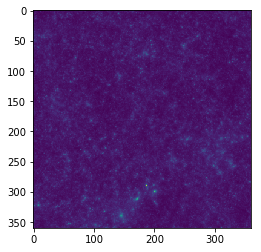

In [10]:
batch = next(train_set)
print(batch.keys())
imshow(batch['x'][0,...,0])

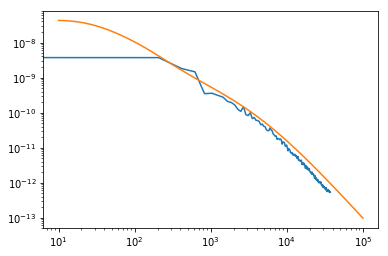

In [11]:
ps_data_th = onp.load(gaussian_path).astype('float32')
ell, power_spectrum_1d = measure_power_spectrum(batch['x'][0,...,0], pixel_size)
ps_data_map = jnp.stack([ell, power_spectrum_1d], axis=0)
loglog(ps_data_map[0,:], ps_data_map[1,:])
loglog(ps_data_th[0,:], ps_data_th[1,:])

In [12]:
def forward(x, s, is_training=False):
    if model_version == 'SmallUResNet':
        denoiser = SmallUResNet(n_output_channels=1, variant='EiffL')
    elif model_version == 'MediumUResNet':
        denoiser = MediumUResNet()
    return denoiser(x, s, is_training=is_training)

model = hk.transform_with_state(forward)

#sn_fn = hk.transform_with_state(lambda x: hk.SNParamsTree(ignore_regex='[^?!.]*b$')(x))
#sn_fn = hk.transform_with_state(lambda x: CustomSNParamsTree(ignore_regex='[^?!.]*b$',val=2.)(x))

In [13]:
# import trained model weights
model_name = "model-35000.pckl"
#model_name = "model-final.pckl"

with open(weight_dir+'/'+ model_name, 'rb') as file: 
    params, state, sn_state = pickle.load(file)

In [14]:
def log_gaussian_prior(map_data, sigma, ps_map):
    data_ft = jnp.fft.fft2(map_data) / float(map_size)
    return -0.5*jnp.sum(jnp.real(data_ft*jnp.conj(data_ft)) / (ps_map+sigma[0]**2))

gaussian_prior_score = jax.vmap(jax.grad(log_gaussian_prior), in_axes=[0,0, None])

In [15]:
def score_fn(params, state, rng_key, batch, is_training=True):
    if gaussian_prior:
        # If requested, first compute the Gaussian prior
        gaussian_score = gaussian_prior_score(batch['y'][...,0], batch['s'][...,0], power_map_th)
        gaussian_score = jnp.expand_dims(gaussian_score, axis=-1)
        net_input = jnp.concatenate([batch['y'], jnp.abs(batch['s'])**2 * gaussian_score],axis=-1)
        res, state = model.apply(params, state, rng_key, net_input, batch['s'], is_training=is_training)
    else:
        res, state = model.apply(params, state, rng_key, batch['y'], batch['s'], is_training=is_training)
        gaussian_score = jnp.zeros_like(res)
    return batch, res, gaussian_score

score_fn = partial(score_fn, params, state, next(rng_seq))

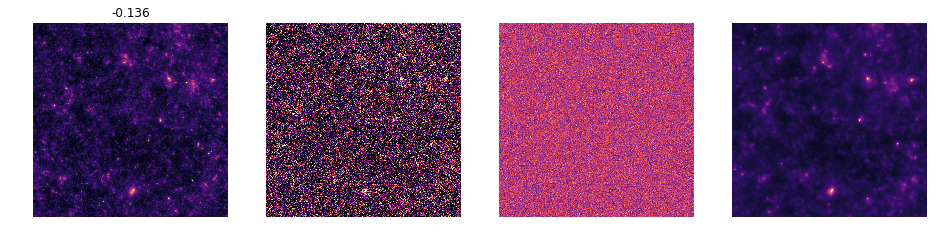

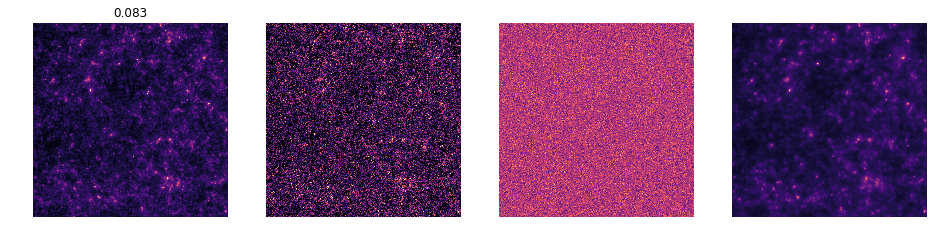

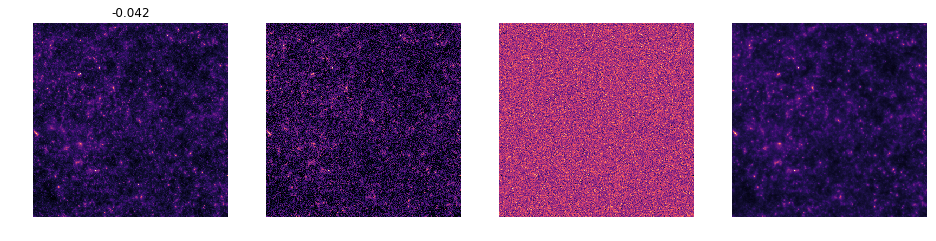

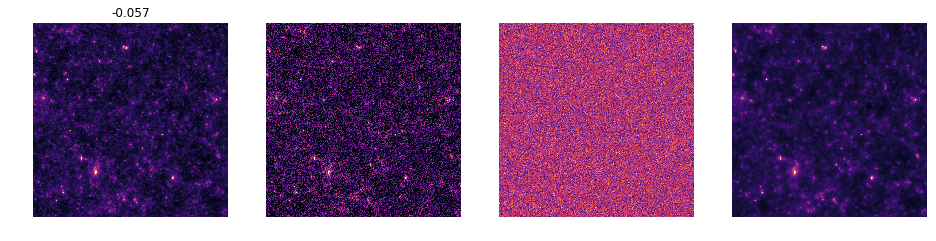

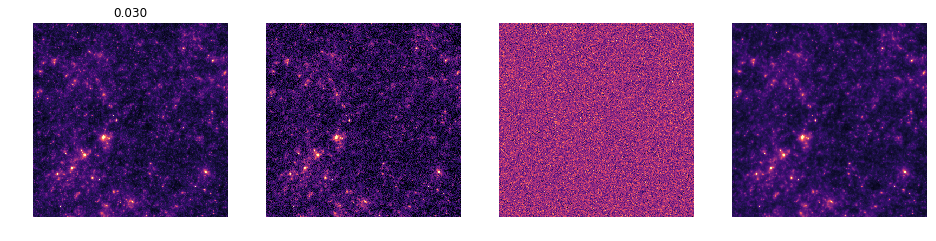

In [16]:
batch = next(train_set)
#res, state = score_fn(batch['x'],batch['s'], is_training=False)
_, res, gaussian_score = score_fn(batch)

for i in range(5):
    ind = i
    figure(figsize=(16,4))
    subplot(141)
    title("%0.3f"%batch['s'][ind,0,0,0])
    imshow(batch['x'][ind,...,0],cmap='magma',vmin=-0.05,vmax=0.3)
    axis('off')
    subplot(142)
    imshow(batch['y'][ind,...,0],cmap='magma',vmin=-0.05,vmax=0.3)
    axis('off')
    subplot(143)
    #imshow(res[ind,...,0],cmap='magma')
    imshow(res[ind,...,0] + gaussian_score[ind,...,0], cmap='magma')
    axis('off')
    #title("%0.3f"%std(batch['s'][ind,:,:,0]**2 * res[ind,...,0]))
    subplot(144)
    #imshow(batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * res[ind,...,0],cmap='magma',vmin=-0.05,vmax=0.3)
    imshow(batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * (res[ind,...,0] + gaussian_score[ind,...,0]),cmap='magma',vmin=-0.05,vmax=0.3)
    #batch['s'] * (res + gaussian_score))**2
    axis('off')

[[0.08296748]]


(-0.5, 359.5, 359.5, -0.5)

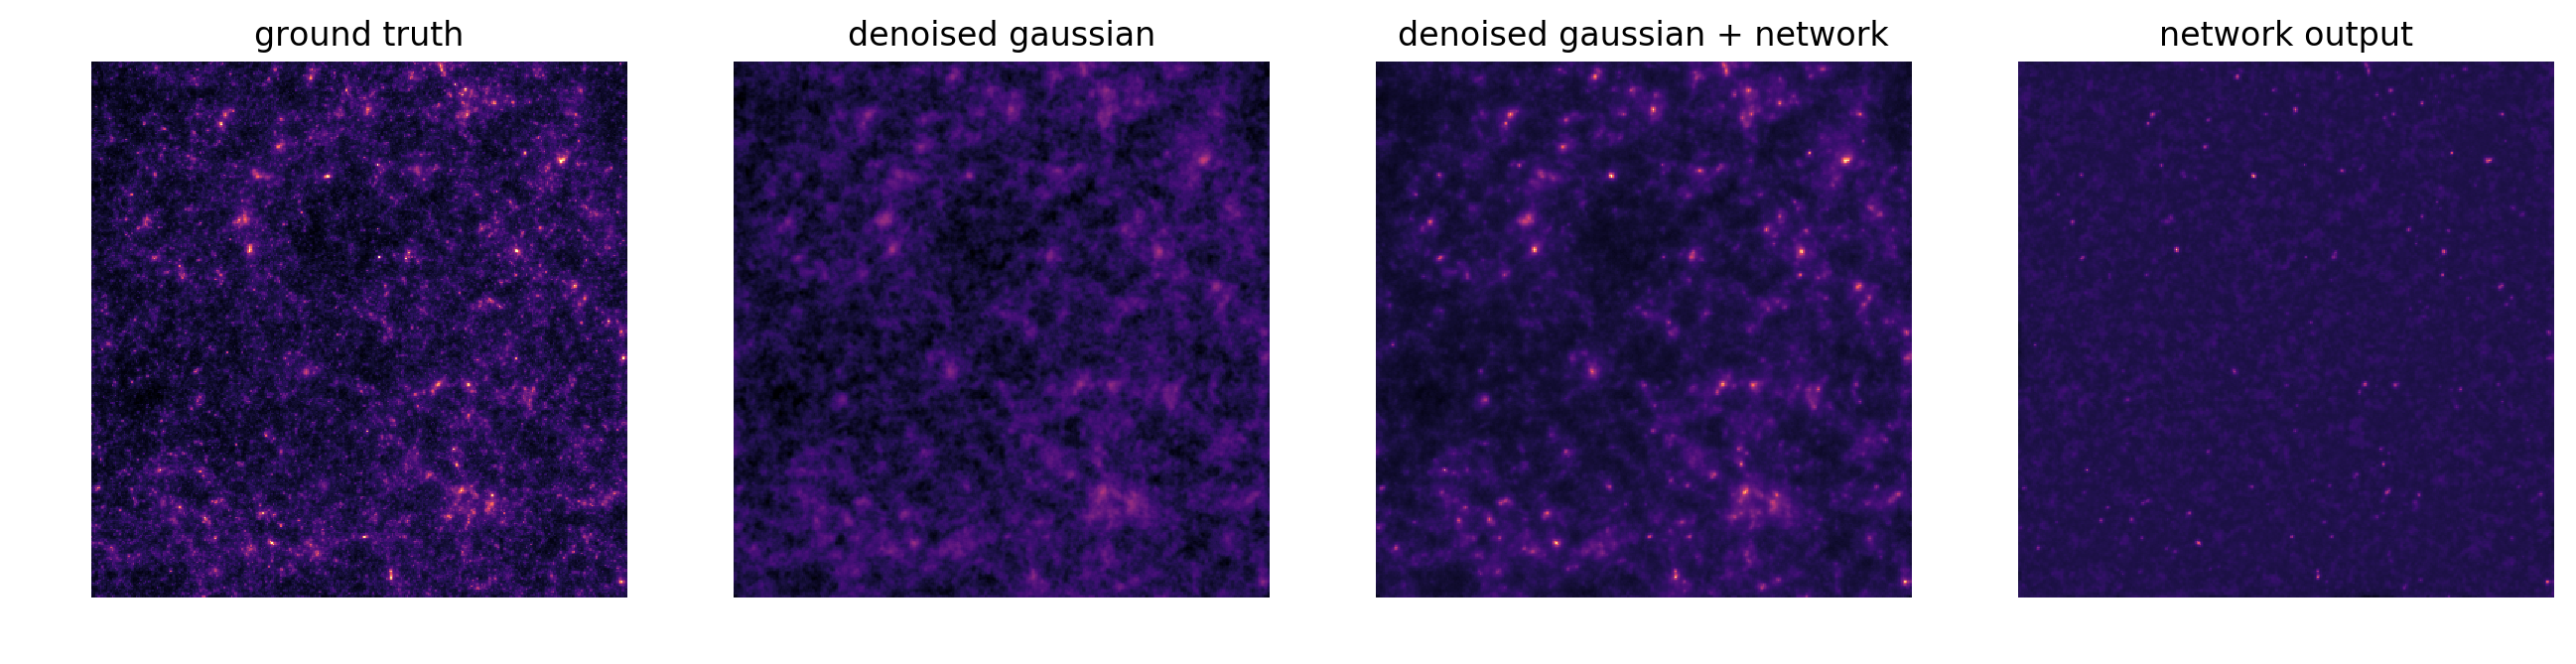

In [17]:
figure(figsize=(16,4), dpi=200)

ind = 1

print(batch['s'][ind,:,:,0])
#style.use('dark_background')
vmax = 0.3

subplot(141)

imshow(batch['x'][ind,...,0],cmap='magma',vmin=-0.05,vmax=vmax)
title('ground truth')
#colorbar()
axis('off')

subplot(142)

imshow(batch['y'][ind,...,0] + (batch['s'][ind,:,:,0]**2) *(gaussian_score[ind,...,0]), cmap='magma', vmin=-0.05,vmax=vmax)
title('denoised gaussian')
axis('off')
#colorbar()

subplot(143)

imshow(batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * (res[ind,...,0] + gaussian_score[ind,...,0]),cmap='magma',vmin=-0.05,vmax=vmax)
title('denoised gaussian + network')
axis('off')
#title("%0.3f"%std(batch['s'][ind,:,:,0]**2 * res[ind,...,0]))
#colorbar()

subplot(144)

imshow((batch['s'][ind,:,:,0]**2) * res[ind,...,0], cmap='magma',vmin=-0.05,vmax=vmax)
title('network output')
axis('off')

#savefig('gauss-res.png')

## Annealed sampling

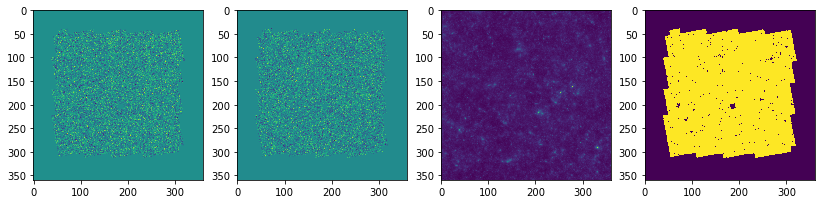

In [18]:
meas_shear = fits.getdata('../data/ktng/ktng_cosmos_e360.fits').astype('float32')
convergence = fits.getdata('../data/ktng/ktng_cosmos_kappa360.fits').astype('float32')
mask = fits.getdata('../data/COSMOS/cosmos_full_mask_0.29arcmin360copy.fits').astype('float32')

#meas_shear = jnp.stack(ks93inv(convergence, jnp.zeros_like(convergence)), axis=-1)

mask = jnp.expand_dims(mask, -1)
masked_true_shear = meas_shear * mask

figure(figsize(14,5))
subplot(141)
imshow(masked_true_shear[..., 0])
subplot(142)
imshow(masked_true_shear[..., 1])
subplot(143)
imshow(convergence)
subplot(144)
imshow(mask[...,0])

In [19]:
def log_likelihood(x, sigma, meas_shear, mask):
    """ Likelihood function at the level of the measured shear
    """
    ke = x.reshape((map_size, map_size))
    kb = jnp.zeros(ke.shape)
    model_shear = jnp.stack(ks93inv(ke, kb), axis=-1)
    #if FLAGS.reduced_shear:
    #    model_shear = model_shear /( 1. - jnp.clip(jnp.expand_dims(ke,axis=-1), -1., 0.9))
    return - jnp.sum(mask*(model_shear - meas_shear)**2/((sigma_gamma)**2 + sigma**2) )/2.

likelihood_score = jax.vmap(jax.grad(log_likelihood), in_axes=[0,0, None, None])

In [20]:
def score_prior(x, sigma):
    net_input = {'y':x.reshape(-1,360, 360,1), 's':sigma.reshape(-1,1,1,1)}
    _, res, gaussian_score = score_fn(net_input)
    return (res[..., 0:1] + gaussian_score).reshape(-1, 360*360)
    #return res[..., 0:1].reshape(-1, 360*360), gaussian_score.reshape(-1, 360*360)

In [21]:
def total_score_fn(x, sigma):
    sl = likelihood_score(x, sigma, meas_shear, mask).reshape(-1, 360*360)
    sp = score_prior(x, sigma)
    return (sl + sp).reshape(-1, 360*360)

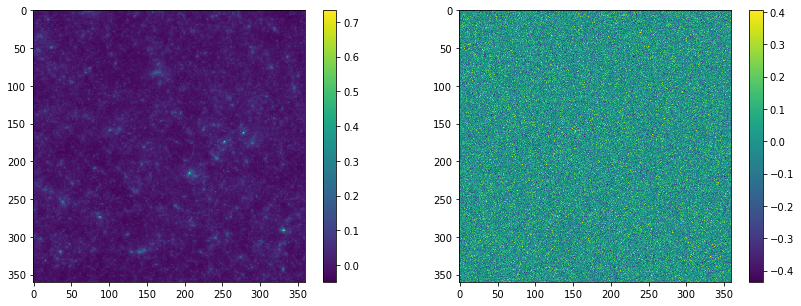

In [22]:
import numpy as onp
kappa_init = onp.random.randn(map_size, map_size) * 0.1
#kappa_init = jnp.expand_dims(kappa_init, axis=0)
sigma = jnp.zeros((1,1,1))

# Initialize with KS93
subplot(121)
imshow(convergence)
colorbar()
subplot(122)
imshow(kappa_init)
colorbar()

kappa_init = jnp.expand_dims(kappa_init, axis=0)

In [23]:
gaussian_prior_score(kappa_init, sigma, power_map_th)

DeviceArray([[[-127.86792 , -115.38049 ,  497.16577 , ...,   85.56008 ,
               -529.6228  , -650.07886 ],
              [-246.6521  ,  -61.323715, -466.92148 , ..., -310.46643 ,
                188.82442 ,  735.1435  ],
              [ 400.0297  ,  565.6064  ,  -92.536804, ...,  361.35333 ,
                195.20291 , -343.38986 ],
              ...,
              [-209.13449 , -996.05884 ,  900.8849  , ...,  716.3583  ,
               -579.85736 ,  527.9434  ],
              [-313.6008  ,  333.9655  , -970.9917  , ...,  136.86795 ,
                -63.830986,  -76.535324],
              [ 277.19107 , -218.5456  ,  538.8447  , ..., -644.9833  ,
                773.3954  ,  340.87634 ]]], dtype=float32)

In [24]:
likelihood_score(kappa_init, sigma, meas_shear, mask).reshape(-1, 360*360).shape

(1, 129600)

In [25]:
score_prior(kappa_init, sigma).shape

(1, 129600)

In [26]:
total_score_fn(kappa_init, sigma).shape

(1, 129600)

In [27]:
#gamma_init = (jnp.repeat(jnp.expand_dims(mask*gamma,0), 1, axis=0) +
#                jnp.expand_dims((1. - mask)*FLAGS.sigma_gamma,0)*onp.random.randn(FLAGS.batch_size, 320, 320, 2))
#gamma = jnp.stack()
#true_shear.shape

In [28]:
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
from jax_lensing.samplers.score_samplers import ScoreHamiltonianMonteCarlo, ScoreMetropolisAdjustedLangevinAlgorithm
from jax_lensing.samplers.tempered_sampling import TemperedMC

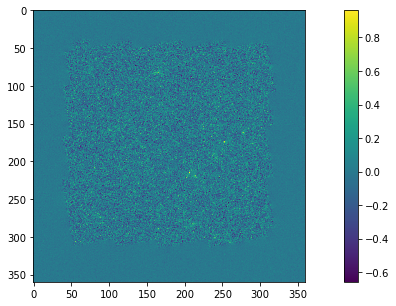

In [71]:
import numpy as onp
#sigma_gamma = 0.15

batch_size = 1
initial_temperature = 0.15
delta_tmp = onp.sqrt(initial_temperature**2 - sigma_gamma**2)
initial_step_size = 0.0012
min_steps_per_temp = 10
#init_image = (delta_tmp*randn(1,360,360)).reshape((-1, 360*360,)).astype('float32')
init_image, _ = ks93(mask[...,0]*meas_shear[...,0], mask[...,0]*meas_shear[...,1])
init_image += (delta_tmp*randn(1,360,360))
#init_image = init_image.reshape((-1, 360*360,)).astype('float32')

init_image = jnp.repeat(init_image, batch_size, axis=0)

imshow(init_image[2,...].reshape(360, 360))
colorbar()

In [ ]:
%%time

def make_kernel_fn(target_log_prob_fn, target_score_fn, sigma):
  return ScoreHamiltonianMonteCarlo(
      target_log_prob_fn=target_log_prob_fn,
      target_score_fn=target_score_fn,
      step_size=initial_step_size*(jnp.max(sigma)/initial_temperature)**0.5,
      #step_size=10*(np.max(sigma)/s0)**0.5,
      num_leapfrog_steps=3,
      num_delta_logp_steps=4)

tmc = TemperedMC(
            target_score_fn=total_score_fn,#score_prior,
            inverse_temperatures=initial_temperature*np.ones([batch_size]),
            make_kernel_fn=make_kernel_fn,
            gamma=0.98,
            min_steps_per_temp=min_steps_per_temp,
            num_delta_logp_steps=4)


num_results = int(11e3)
num_burnin_steps = int(0)

samples, trace = tfp.mcmc.sample_chain(
        #num_results=num_results,
        num_results=3,
        current_state=init_image.reshape([batch_size, -1]),
        kernel=tmc,
        num_burnin_steps=num_burnin_steps,
        #num_steps_between_results=1,
        num_steps_between_results=num_results//3,
        trace_fn=lambda _, pkr: (pkr.pre_tempering_results.is_accepted,
                                 pkr.post_tempering_inverse_temperatures,
                                 pkr.tempering_log_accept_ratio),
        seed=jax.random.PRNGKey(0))

"""
samples, trace = tfp.mcmc.sample_chain(
        num_results=3,
        current_state=init_image.reshape([batch_size, -1]),
        kernel=tmc,
        num_burnin_steps=num_burnin_steps,
        num_steps_between_results=num_results//3,
        trace_fn=lambda _, pkr: (pkr.pre_tempering_results.is_accepted,
                                 pkr.post_tempering_inverse_temperatures,
                                 pkr.tempering_log_accept_ratio),
        seed=jax.random.PRNGKey(0))
"""
print(len(samples))
#######
######

[Traced<ShapedArray(float32[1,129600]):JaxprTrace(level=1/0)>]


In [ ]:
figure(figsize=(9,3))
subplot(131)
plot(trace[0]);
title('acceptance')
subplot(132)
plot(trace[1]);
title('temp')
subplot(133)
plot(exp(trace[2]));
title('accept tempering')

In [ ]:
s = samples[-1,...]
sigma = 0.01 * jnp.ones(s.shape[0])
batch = {'y':s.reshape(-1,360, 360,1), 's':sigma.reshape(-1,1,1,1)}
_, res, gaussian_score = score_fn(batch)
res.shape

IndexError: Too many indices for array: 1 non-None/Ellipsis indices for dim 0.

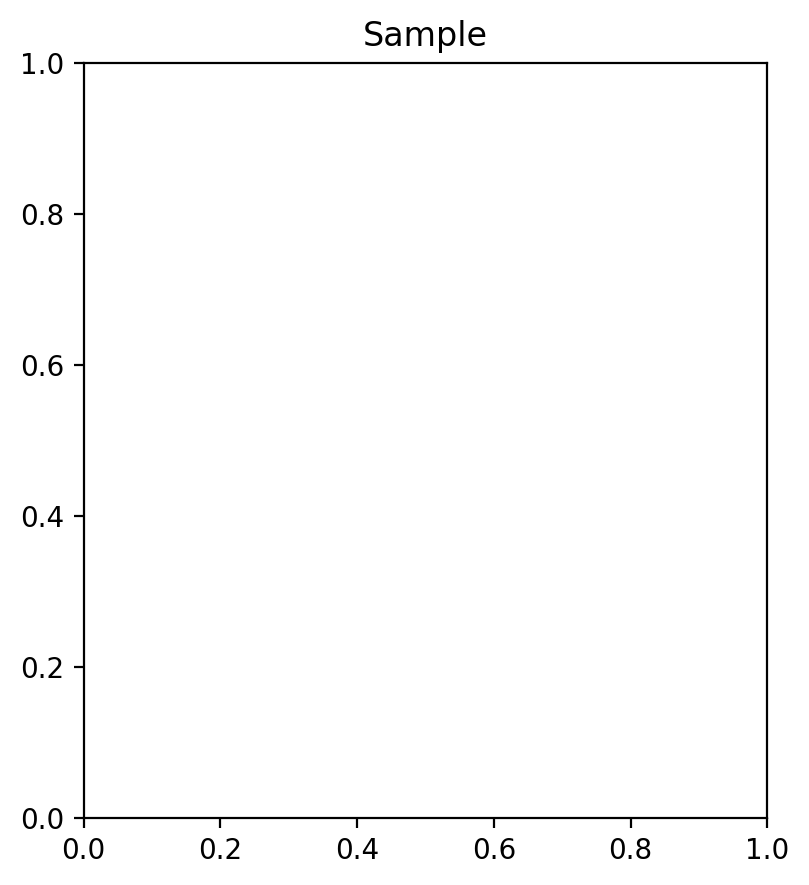

In [84]:
vmin = -0.1
vmax = 0.3

figure(figsize=(15,5), dpi=200)
subplot(131)
title('Sample')
imshow(samples[-1][0,...].reshape(360,360), cmap='magma', vmin=vmin, vmax=vmax);
axis('off')
colorbar()

#subplot(132)
#imshow(batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * (res[ind,...,0] + gaussian_score[ind,...,0]),cmap=cmap,vmin=vmin,vmax=vmax)
#title('denoised gaussian + network')


subplot(133)
title('Ground truth')
imshow(convergence, cmap='magma', vmin=vmin, vmax=vmax);
axis('off')
colorbar()

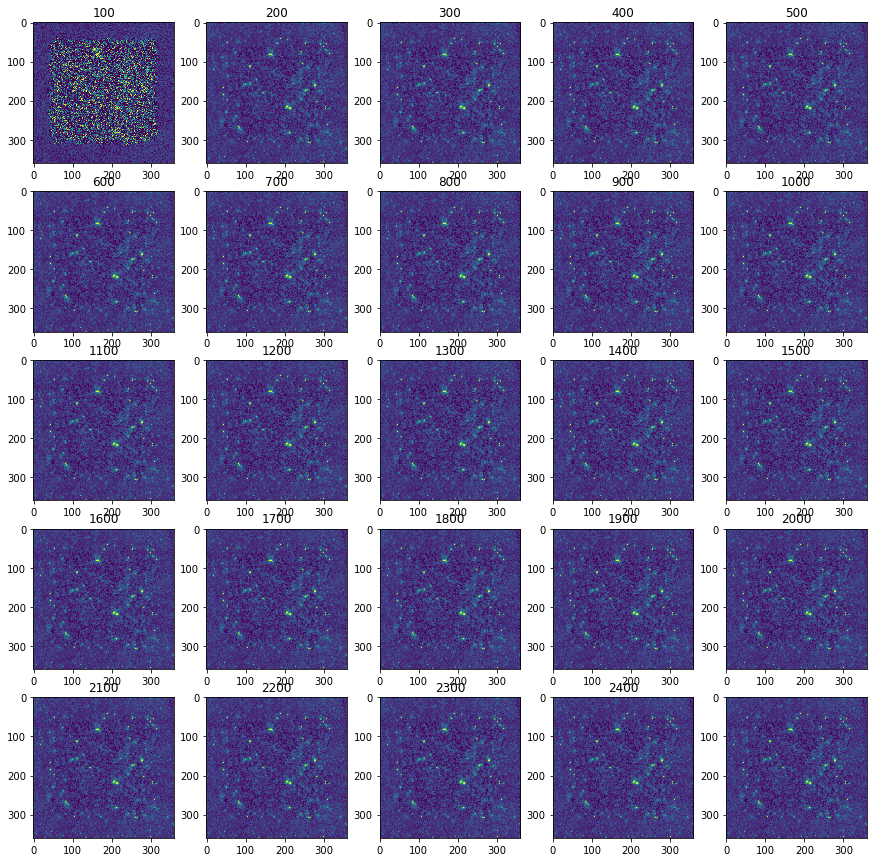

In [75]:
scale = 100
figure(figsize=[15,15])
for i in range(5):
    for j in range(5):
        title(str((i*5+j)*scale))
        subplot(5,5,i*5+j+1)
        imshow(samples[(i*5+j)*scale].reshape(360, 360), vmin=-0.05,vmax=0.3)

IndexError: Too many indices for array: 1 non-None/Ellipsis indices for dim 0.

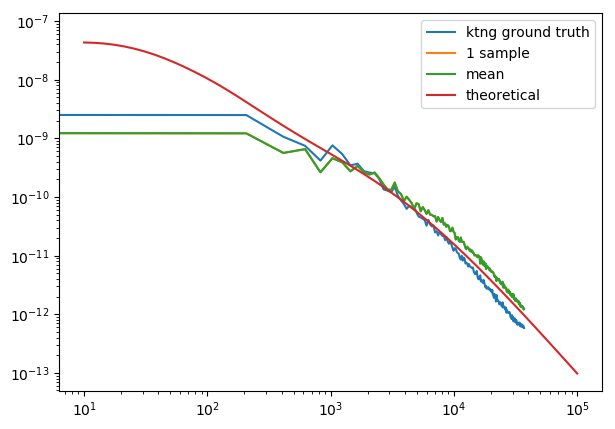

In [76]:
figure(figsize=(7,5), dpi=100)

ell, ps_gt = measure_power_spectrum(convergence, pixel_size)
ps_data_gt = jnp.stack([ell, ps_gt], axis=0)
loglog(ps_data_gt[0,:], ps_data_gt[1,:], label='ktng ground truth')

ell, ps_sample = measure_power_spectrum(samples[-1][0,...].reshape(360,360), pixel_size)
ps_data_sample = jnp.stack([ell, ps_sample], axis=0)
loglog(ps_data_sample[0,:], ps_data_sample[1,:], label='1 sample')

ell, ps_mean = measure_power_spectrum(jnp.median(samples[-1], axis=0).reshape(360,360), pixel_size)
ps_data_mean = jnp.stack([ell, ps_mean], axis=0)
loglog(ps_data_mean[0,:], ps_data_mean[1,:], label='mean')


loglog(ps_data_th[0,:], ps_data_th[1,:], label='theoretical')

legend()

In [77]:
#12e3 0.0015
#a = samples[-1][0,...].reshape(360,360)

#8e3 0.0015
#b = samples[-1][0,...].reshape(360,360)

#8e3 0.002
#b = samples[-1][0,...].reshape(360,360)

In [32]:
%%time

def make_kernel_fn(target_log_prob_fn, target_score_fn, sigma):
  return ScoreHamiltonianMonteCarlo(
      target_log_prob_fn=target_log_prob_fn,
      target_score_fn=target_score_fn,
      step_size=initial_step_size*(jnp.max(sigma)/initial_temperature)**0.5,
      #step_size=10*(np.max(sigma)/s0)**0.5,
      num_leapfrog_steps=3,
      num_delta_logp_steps=4)

tmc = TemperedMC(
            target_score_fn=total_score_fn,#score_prior,
            inverse_temperatures=initial_temperature*np.ones([batch_size]),
            make_kernel_fn=make_kernel_fn,
            gamma=0.98,
            min_steps_per_temp=min_steps_per_temp,
            num_delta_logp_steps=4)


num_results = int(5e3)
num_burnin_steps = int(0)


samples, trace = tfp.mcmc.sample_chain(
        num_results=3,
        current_state=init_image.reshape([batch_size, -1]),
        kernel=tmc,
        num_burnin_steps=num_burnin_steps,
        num_steps_between_results=num_results//3,
        trace_fn=lambda _, pkr: (pkr.pre_tempering_results.is_accepted,
                                 pkr.post_tempering_inverse_temperatures,
                                 pkr.tempering_log_accept_ratio),
        seed=jax.random.PRNGKey(0))
"""

num_steps = int(5e3)
output_steps = 2
num_burnin_steps = int(0)
samples, trace = tfp.mcmc.sample_chain(
          num_results=num_steps,
          current_state=init_image.reshape([batch_size, -1]),
          kernel=tmc,
          num_burnin_steps=0,
          num_steps_between_results=num_steps//output_steps,
          trace_fn=lambda _, pkr: (pkr.pre_tempering_results.is_accepted,
                                   pkr.post_tempering_inverse_temperatures,
                                   pkr.tempering_log_accept_ratio),
          seed=jax.random.PRNGKey(0))

"""
print(len(samples))
#######
######

ValueError: vmap in_axes specification must be a tree prefix of the corresponding value, got specification (0, 0, None, None) for value tree PyTreeDef(tuple, [*,*]).

Text(0.5,1,'accept tempering')

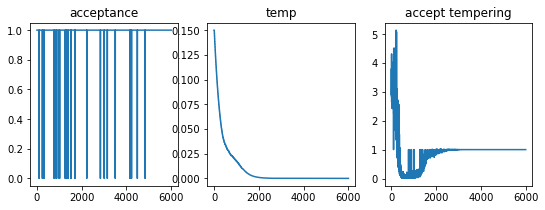

In [28]:
figure(figsize=(9,3))
subplot(131)
plot(trace[0]);
title('acceptance')
subplot(132)
plot(trace[1]);
title('temp')
subplot(133)
plot(exp(trace[2]));
title('accept tempering')

(-0.5, 359.5, 359.5, -0.5)

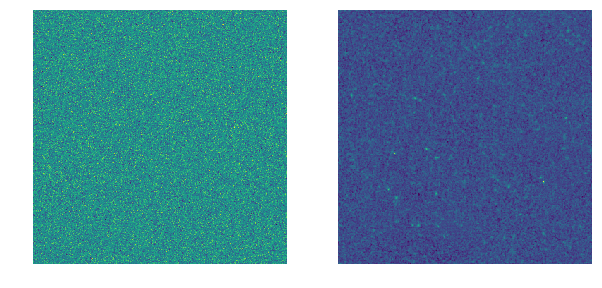

In [29]:
figure(figsize=(10,5))
subplot(121)
imshow(samples[0].reshape((360, 360))); axis('off')
subplot(122)
imshow(samples[-1].reshape((360, 360))); axis('off')

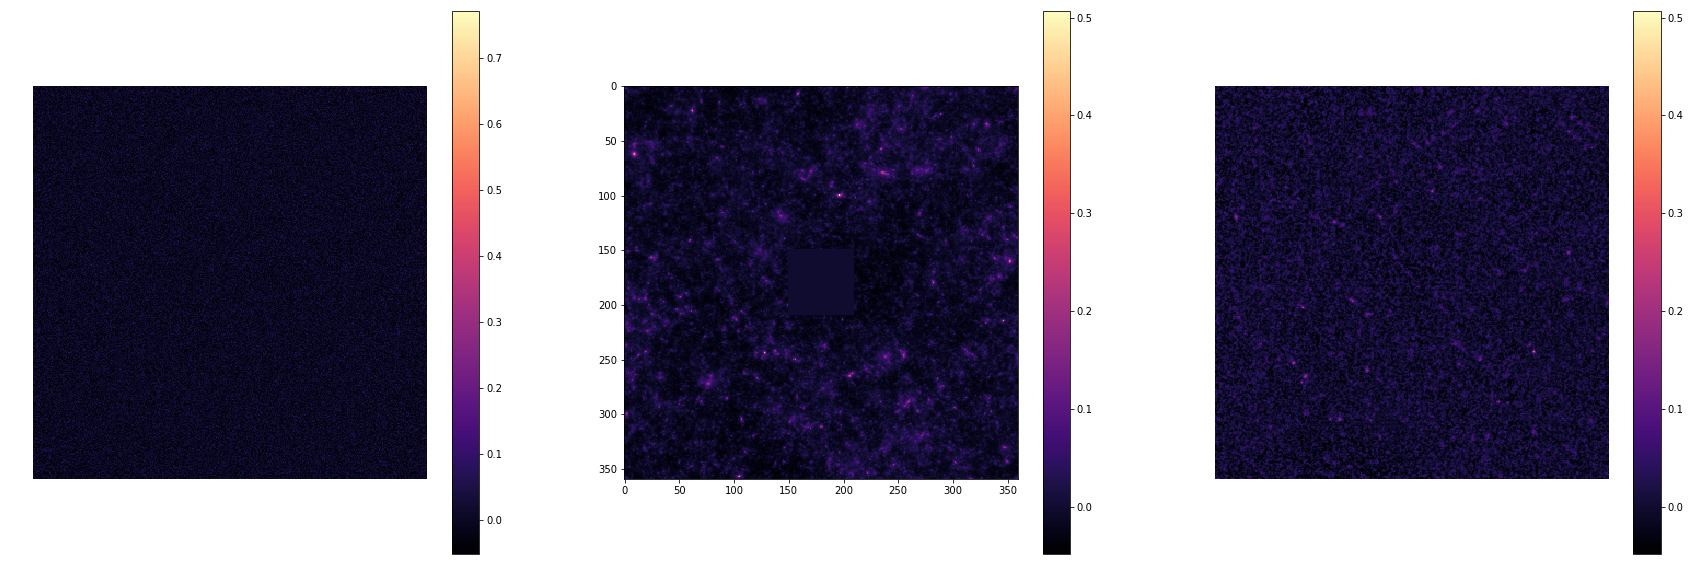

In [30]:
figure(figsize=(30,10))
subplot(131)
imshow(samples[0].reshape((360, 360)),cmap='magma', vmin=batch['x'].min(), vmax=batch['x'].max()); axis('off')
colorbar()
subplot(132)
imshow(x_masked[0,...,0],cmap='magma', vmin=x[0,...,0].min(), vmax=x[0,...,0].max())
colorbar()
subplot(133)
imshow(samples[-1].reshape((360, 360)), cmap='magma', vmin=x[0,...,0].min(), vmax=x[0,...,0].max())
axis('off')
colorbar()

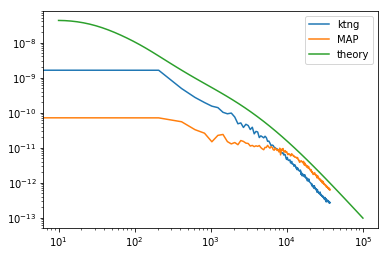

In [33]:
resolution_ktng = 0.29 # pixel resolution: 0.29 arcmin/pixel
pixel_size_ktng = np.pi * resolution_ktng / 180. / 60. #rad/pixel

ell_true, ps_true = measure_power_spectrum(x[0,...,0].reshape(360,360), pixel_size_ktng, resolution_ktng)
ell_map, ps_map = measure_power_spectrum(samples[-1].reshape(360, 360), pixel_size_ktng, resolution_ktng)

ps_data = onp.load(gaussian_path).astype('float32')

loglog(ell_true, ps_true, label='ktng')
loglog(ell_map, ps_map, label='sample')
loglog(ps_data[0,:], ps_data[1,:], label='theory')
legend()

In [ ]:
figure(figsize=[15,15])
for i in range(5):
    for j in range(5):
        subplot(5,5,i*5+j+1)
        imshow(samples[(i*5+j)*170].reshape(360, 360), vmin=-0.05,vmax=0.3)

In [ ]:
score_posterior()

In [ ]:
#imshow(delta_tmp*onp.random.randn(360, 360))